# Préliminaires

- ## Introduction :  sujet et objectif

- ## Imports des librairies utiles

In [1]:
import math
import json
import pandas as pd
pd.set_option('display.max_columns', 300)
import numpy as np
from datetime import datetime, date, timedelta
from dateutil.relativedelta import *

#pour la partie data viz
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
from bokeh.io import output_notebook
output_notebook()

from sklearn.decomposition import PCA

import folium

Loading BokehJS ...

# I. Table de données brutes

- ## Chargement des données :

***Load and join data to create the complete dataset***

In [2]:
df = pd.read_excel('../data/synthese.xlsx')
aux = pd.read_excel('../data/extrait_2.xlsx')

In [3]:
df.head()

,N_ordre,type hosp,annee,nb_rhs,nb_jours_total,nb_jours_semaine,nb_jours_WE,GME_ATIH,chapitre,T_chapitre,GN,T_GN,RGME,dep_sup,dep_physique,dep_totale,annee_naissance,sexe,entree,sortie,Animateur,Assistant de service social,Autre intervenant,Diététicien,Éducateur spécialisé,Éducateur sportif,Enseignant général,Ergonome,Ergothérapeute,Infirmier,Masseurkinésithérapeute,Médecin,Moniteur d’autoécole,Moniteur éducateur,Orthophoniste,Orthoprothésiste,Osteopathe,Psychologue,Psychomotricien
0,498,1,2014,12,79,57,22,0863C1,8,CH08,863,GN0863,0863c,4,12,15,1952,1,7,6.0,NaN,NaN,644.0,NaN,NaN,NaN,NaN,NaN,NaN,180.0,4713.0,144.0,NaN,NaN,NaN,NaN,NaN,194.0,NaN
1,503,1,2014,12,77,55,22,0115D1,1,CH01,115,GN0115,0115d,5,11,15,1946,1,7,6.0,NaN,150.0,NaN,NaN,NaN,380.0,NaN,NaN,2894.0,132.0,3720.0,120.0,NaN,NaN,NaN,NaN,NaN,633.0,NaN
2,507,2,2014,11,55,55,0,0112A0,1,CH01,112,GN0112,0112a,2,4,6,1962,1,8,8.0,NaN,NaN,828.0,NaN,NaN,868.0,NaN,NaN,792.0,36.0,2449.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,508,1,2014,15,99,71,28,0121B2,1,CH01,121,GN0121,0121b,5,9,14,1958,1,7,6.0,NaN,24.0,92.0,NaN,NaN,711.0,NaN,NaN,1788.0,156.0,5383.0,168.0,NaN,NaN,30.0,NaN,NaN,57.0,NaN
4,514,1,2014,11,69,49,20,0112C2,1,CH01,112,GN0112,0112c,8,12,20,1996,1,7,6.0,NaN,575.0,NaN,NaN,NaN,NaN,NaN,NaN,1815.0,118.0,3910.0,108.0,NaN,NaN,193.0,NaN,NaN,248.0,NaN


In [4]:
aux.head()

,N_ordre,date,CP,jour,mois,annee,date_2
0,1,11102012,62121,11,10,2012,11/10/2012
1,2,29102012,62118,29,10,2012,29/10/2012
2,3,31102012,62000,31,10,2012,31/10/2012
3,4,8112012,62450,8,11,2012,08/11/2012
4,5,14112012,62000,14,11,2012,14/11/2012


In [5]:
#drop useless
to_drop = ["annee","GME_ATIH","chapitre","GN","RGME","sortie",u'Médecin',"dep_totale"]
target = ["nb_jours_semaine"]
target_related = [ u'nb_rhs', u'nb_jours_total', u'nb_jours_WE']

df = df.drop(to_drop,axis=1)
aux= aux.drop(["date"], axis = 1).rename({"date_2":"date_entree","jour":"jour_entree","mois":"mois_entree",
                                         "annee":"annee_entree"}, axis=1)

In [6]:
#retreat date type such as date
aux["date_entree"]= pd.to_datetime(aux["date_entree"])

In [7]:
#check key on left
print("Left table has %s duplicates on key." %(len(df)-len(df.drop_duplicates(["N_ordre"]))))
#check key on right
print("Right table has %s duplicates on key." %(len(aux)-len(aux.drop_duplicates(["N_ordre"]))))

#left join on N_ordre
data = pd.merge(df,aux,on="N_ordre",how="left")

Left table has 0 duplicates on key.
Right table has 0 duplicates on key.


In [8]:
#calcul du succès de jointures
print("Success rate of left join: %s%% complete." %((len(data)-data["CP"].isna().sum())/float(len(data))*100))

Success rate of left join: 100.0% complete.


In [9]:
data.columns

Index([                    u'N_ordre',                   u'type hosp',
                            u'nb_rhs',              u'nb_jours_total',
                  u'nb_jours_semaine',                 u'nb_jours_WE',
                        u'T_chapitre',                        u'T_GN',
                           u'dep_sup',                u'dep_physique',
                        u'dep_totale',             u'annee_naissance',
                              u'sexe',                      u'entree',
                         u'Animateur', u'Assistant de service social',
                 u'Autre intervenant',                 u'Diététicien',
              u'Éducateur spécialisé',           u'Éducateur sportif',
                u'Enseignant général',                    u'Ergonome',
                    u'Ergothérapeute',                   u'Infirmier',
           u'Masseurkinésithérapeute',        u'Moniteur d’autoécole',
                u'Moniteur éducateur',               u'Orthophoniste',
      

In [10]:
#médecin est de mauvaise qualité

print("Printing basic data info:")
print("\tData Shape %s rows and %s columns"  %data.shape)

Printing basic data info:
	Data Shape 37199 rows and 37 columns


- ## Description qualitative des données

In [11]:
def summarize(df):
    #summary
    summary =  pd.DataFrame()
    cols = list(df.columns)
    summary["column"] =  cols
    summary["type"] = list(df[cols].dtypes)
    summary["nb_missing_values"] = list(df[cols].isnull().sum())
    summary["nb_missing_values%"] = summary["nb_missing_values"]/len(df)*100
    summary["nb_unique"]= [df[x].dropna().nunique() for x in summary["column"]]
    summary.set_index("column",inplace=True)
    return summary


In [12]:
summarize(data)

,type,nb_missing_values,nb_missing_values%,nb_unique
column,,,,
N_ordre,int64,0,0.000000,37199
type hosp,int64,0,0.000000,2
nb_rhs,int64,0,0.000000,122
nb_jours_total,int64,0,0.000000,464
nb_jours_semaine,int64,0,0.000000,367
nb_jours_WE,int64,0,0.000000,188
T_chapitre,object,0,0.000000,16
T_GN,object,0,0.000000,97
dep_sup,int64,0,0.000000,7


***À présent, nous souhaitons connaître les types de chaque variable. À noter que lorsque la variable prend plusieurs types de valeurs, Python nous affiche le type "object". Nous remarquons que les variables numériques sont prédominantes en terme de présence.***

#### II. Analyses simples des données

- ## Etude descriptive de la donnée

In [13]:
#Description de la table
data.describe()

,N_ordre,type hosp,nb_rhs,nb_jours_total,nb_jours_semaine,nb_jours_WE,dep_sup,dep_physique,dep_totale,annee_naissance,sexe,entree,Animateur,Assistant de service social,Autre intervenant,Diététicien,Éducateur spécialisé,Éducateur sportif,Enseignant général,Ergonome,Ergothérapeute,Infirmier,Masseurkinésithérapeute,Moniteur d’autoécole,Moniteur éducateur,Orthophoniste,Orthoprothésiste,Osteopathe,Psychologue,Psychomotricien,CP,jour_entree,mois_entree,annee_entree
count,37199.000000,37199.000000,37199.000000,37199.000000,37199.000000,37199.000000,37199.000000,37199.000000,37199.000000,37199.000000,37199.000000,37199.000000,1209.000000,6512.000000,7663.000000,6137.000000,1071.000000,15614.000000,299.000000,2517.000000,17642.000000,30269.000000,32666.000000,479.000000,646.000000,2048.000000,2374.000000,470.000000,6443.000000,819.000000,37199.000000,37199.000000,37199.000000,37199.000000
mean,25786.358128,1.308100,4.786043,24.954676,19.655448,5.299228,3.862658,7.835022,11.649077,1963.065835,1.463292,7.402726,909.299421,243.165387,227.440689,81.055565,913.431373,781.412450,1888.086957,257.539134,1734.954767,410.872312,1419.063797,337.981211,1715.153251,944.650879,83.743471,193.717021,364.416576,576.663004,63375.790962,15.586010,6.399903,2015.440308
std,11644.376670,0.461714,8.343949,55.342731,40.426132,15.376879,1.625987,3.639283,4.695185,20.560113,0.498657,0.775064,2510.264694,729.222689,549.138808,84.459542,1245.685494,1207.400146,2719.543478,269.762637,3809.181235,1783.713013,2371.703337,213.809562,3137.921494,1712.604149,123.911566,146.468298,766.208960,737.146649,12665.527426,8.838182,3.520950,1.136229
min,498.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,4.000000,6.000000,1915.000000,1.000000,6.000000,10.000000,10.000000,7.000000,8.000000,10.000000,11.000000,10.000000,12.000000,7.000000,6.000000,7.000000,13.000000,10.000000,12.000000,6.000000,51.000000,10.000000,12.000000,0.000000,1.000000,1.000000,2010.000000
25%,16980.500000,1.000000,1.000000,5.000000,5.000000,0.000000,2.000000,5.000000,8.000000,1948.000000,1.000000,7.000000,75.000000,55.000000,14.000000,29.000000,138.000000,200.000000,454.000000,123.000000,140.000000,72.000000,360.000000,211.000000,140.500000,100.000000,14.000000,93.000000,57.000000,120.000000,62122.000000,8.000000,3.000000,2014.000000
50%,26280.000000,1.000000,3.000000,13.000000,10.000000,2.000000,4.000000,7.000000,11.000000,1959.000000,1.000000,8.000000,246.000000,107.000000,43.000000,54.000000,443.000000,430.000000,976.000000,200.000000,582.500000,141.000000,855.000000,344.000000,580.000000,354.000000,35.000000,164.000000,137.000000,300.000000,62290.000000,16.000000,6.000000,2015.000000
75%,35579.500000,2.000000,5.000000,24.000000,20.000000,5.000000,5.000000,10.000000,14.000000,1977.000000,2.000000,8.000000,710.000000,213.000000,200.000000,99.000000,1208.000000,965.000000,2252.000000,310.000000,1761.750000,263.000000,1522.000000,357.000000,1880.250000,1047.000000,93.000000,246.750000,333.000000,765.000000,62730.000000,23.000000,10.000000,2016.000000
max,44893.000000,2.000000,234.000000,1632.000000,1166.000000,466.000000,8.000000,16.000000,24.000000,2017.000000,2.000000,8.000000,26910.000000,23749.000000,11493.000000,1095.000000,8717.000000,34925.000000,22329.000000,4347.000000,98518.000000,45109.000000,106542.000000,1450.000000,32748.000000,36118.000000,1192.000000,1066.000000,17617.000000,7596.000000,99418.000000,31.000000,12.000000,2017.000000


In [14]:
#fill na to 0 for the 
practiciens = [u'Animateur', u'Assistant de service social',
                 u'Autre intervenant',                 u'Diététicien',
              u'Éducateur spécialisé',           u'Éducateur sportif',
                u'Enseignant général',                    u'Ergonome',
                    u'Ergothérapeute',                   u'Infirmier',
           u'Masseurkinésithérapeute',        u'Moniteur d’autoécole',
                u'Moniteur éducateur',               u'Orthophoniste',
                  u'Orthoprothésiste',                  u'Osteopathe',
                       u'Psychologue',             u'Psychomotricien']

for col in practiciens:
    data[col] = data[col].fillna(0)


** Features engineering**

In [34]:
#create age instead at time of entry
data["Age"] = data["annee_entree"] - data["annee_naissance"]

#create indicator for u'nb_jours_WE'
def weekend_indicator(x):
    """input : x scalar"""
    if x < 0.8:
        return 0
    if x>=0.8 and x<1.8:
        return 1
    if x>=1.8:
        return 2
data["weekend_indicator"] = (data["nb_jours_WE"]/data["nb_rhs"]).apply(lambda x :weekend_indicator(x))

#add nombre d'intervenants
def nb_inter(row,practiciens):
    """
    Input:
    row : row of dataframe
    practiciens : métier
    """
    count = 0
    for col in practiciens:
        if row[col]>0:
            count+=1
    return count
data["Nb_intervenants"] = data.apply(lambda row : nb_inter(row,practiciens),axis=1)

data['Total_interventions'] = data[practiciens].sum(axis=1)

In [37]:
#eliminate those who have Nb_intervenants = 0
data = data[data["Nb_intervenants"]>0].reset_index(drop = True)

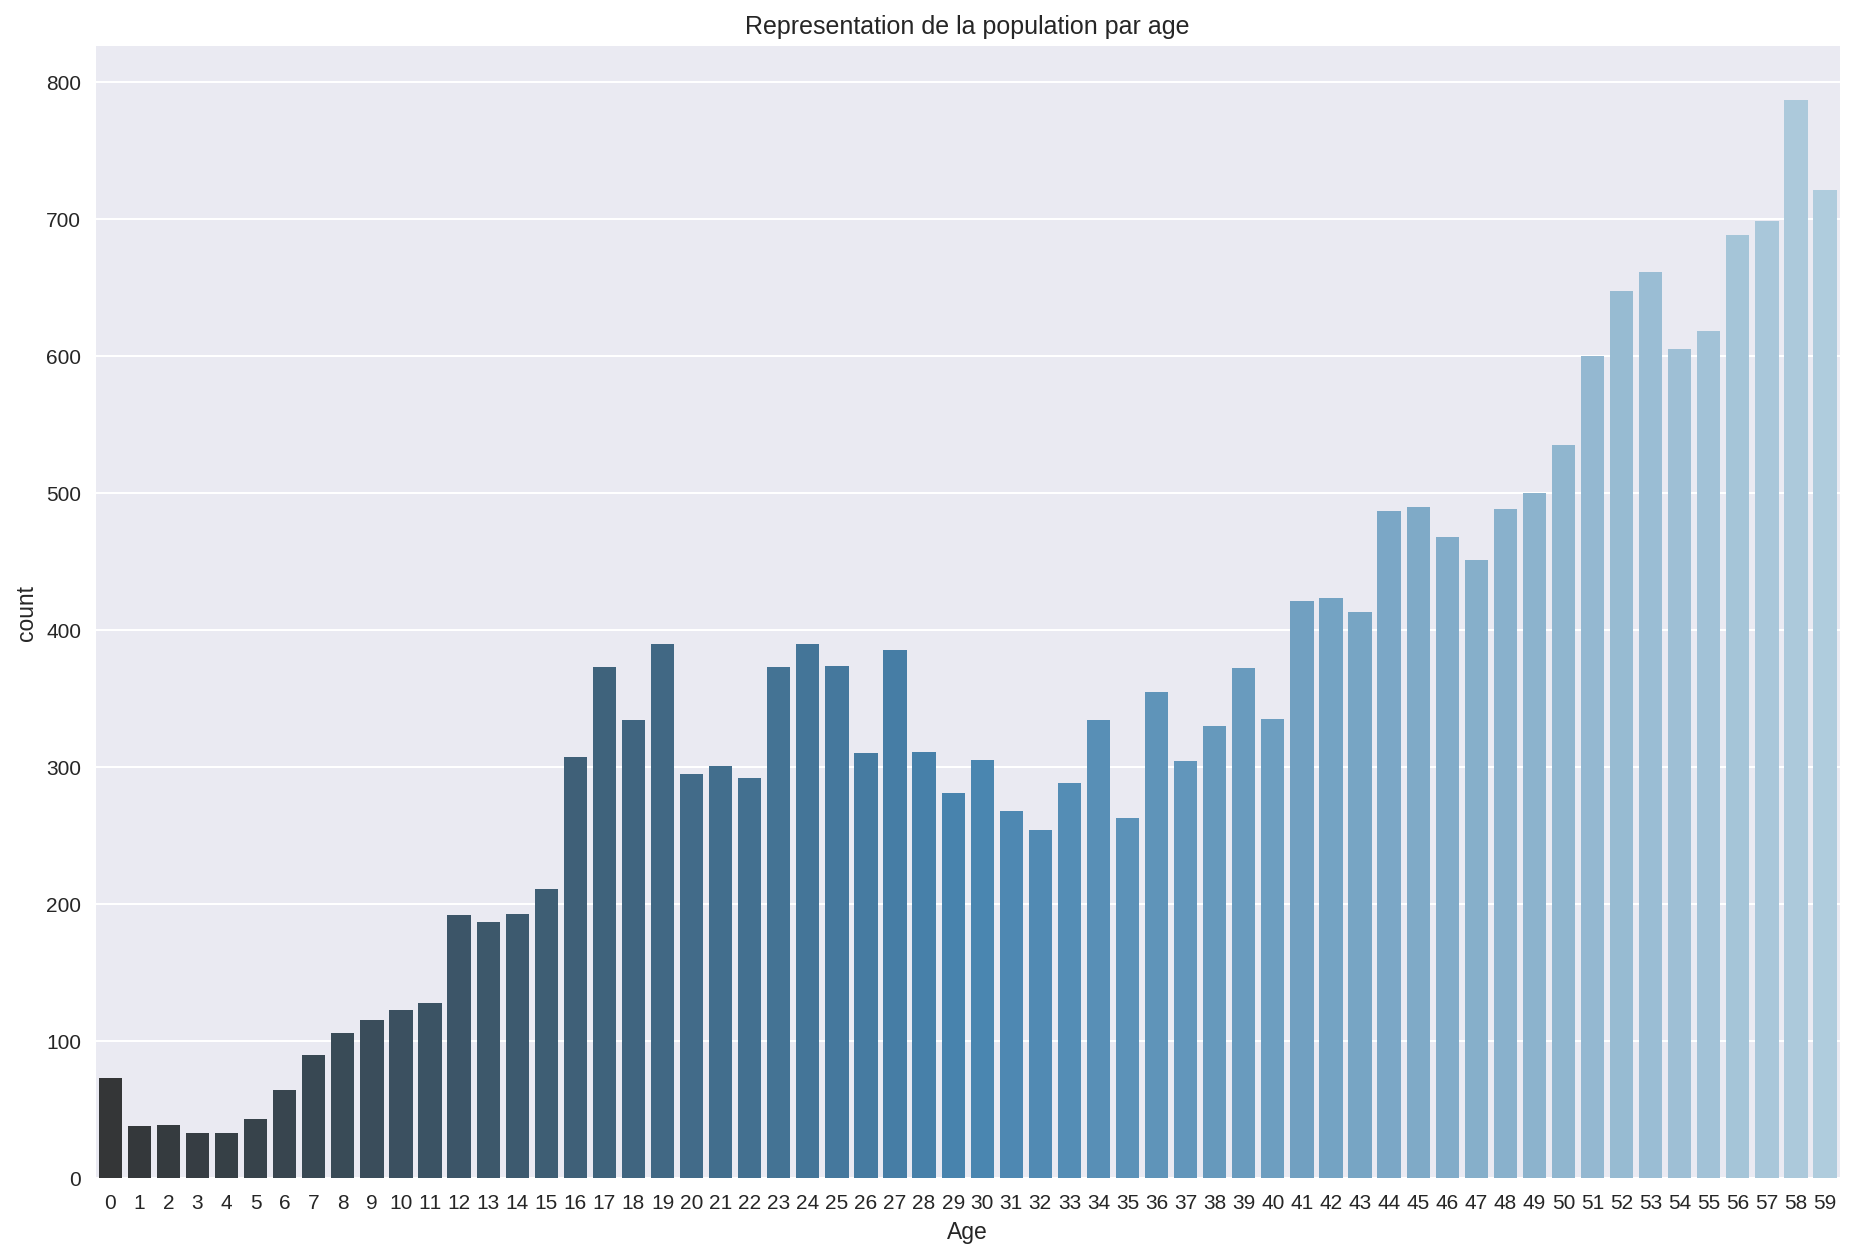

In [38]:
plt.figure(figsize=(15,10),dpi=150)
l=[int(i) for i in list(data['Age'].value_counts().sort_index().index)]
sns.set(style="darkgrid")
ax = sns.countplot(x="Age", order=data['Age'].value_counts().sort_index().index[0:60],data=data,palette='Blues_d')
ax.set_title('Representation de la population par age')
ax.set_xticklabels(l)
ax

- ## Analyse en composantes principales

In [17]:
#Nous faisons volontairement une deep copy de notre table originale, et nous fairons l'ACP sur cette copie. Une simple
#affectation de notre table à une nouvelle table ne suffit pas (sans une deep copy, les traitements opérés sur la copie
#sont également opérés sur la table originale, ce que nous ne voulons pas car nous souhaitons préserver la table
#originale.

new_table=data.copy(deep=True)

#Supprimons à présent les variables qualitatives et les variables non exclusivement quantitatives.

new_table = new_table[["Age","nb_jours_semaine","dep_sup","dep_physique"] + practiciens]

#Suppression des NaN comme ce qui était annoncé précédemment.
new_table_2=new_table.dropna(axis=0,how='any')

In [21]:
#ACP
pca=PCA(n_components=20)
print(pca.fit(new_table_2))
pca.explained_variance_ratio_
s=np.log10(pca.explained_variance_ratio_)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


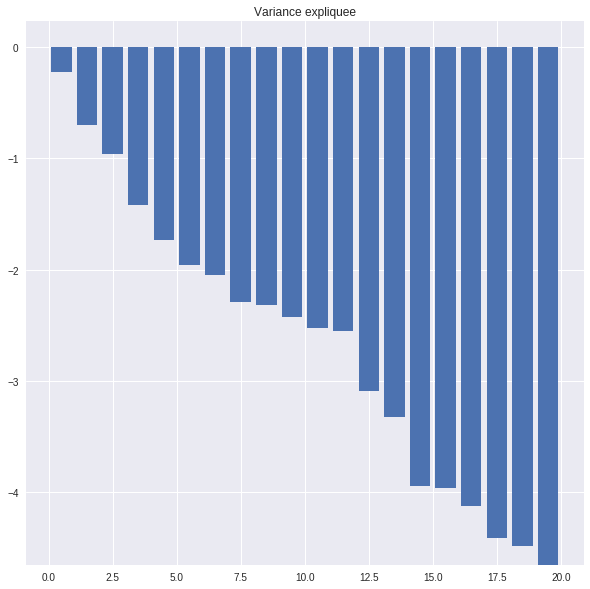

In [22]:
plt.figure(figsize=(10,10))
plt.bar(np.arange(len(s))+0.5, s)
plt.title("Variance expliquee")

# III. Data visualisation

- ## Etude de certains champs

CPU times: user 390 ms, sys: 144 ms, total: 534 ms
Wall time: 341 ms


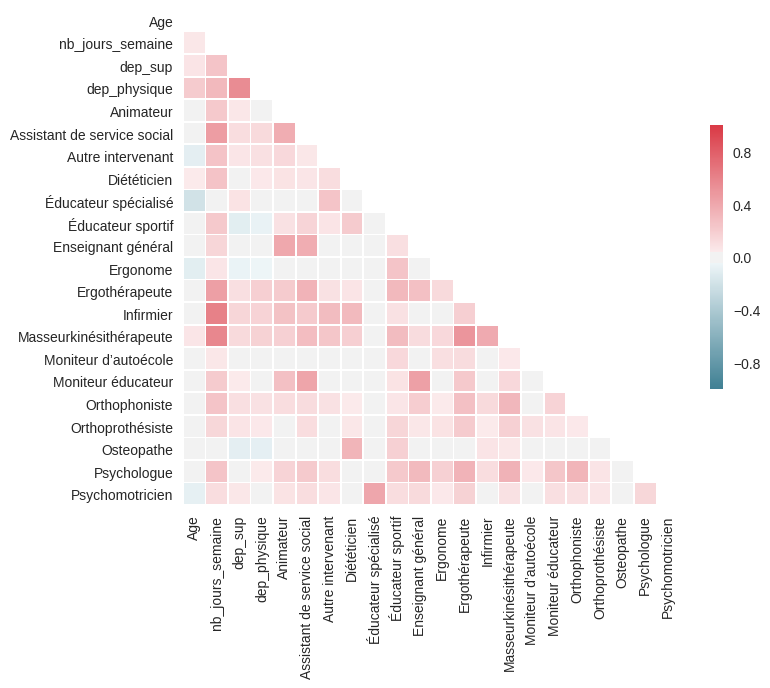

In [24]:
%%time
 #Compute correlation matrix 
#remove categorial features that are numericaly encoded
corr =data[["Age","nb_jours_semaine","dep_sup","dep_physique"] + practiciens].corr()

#Mask for the upper part of the plot
#irrelevant because of symmetry
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

#Init
f, ax = plt.subplots(figsize=(8, 7), dpi=100)

#color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#plot correlation matrix 
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax) #annot=True
            #xticklabels=corr.columns, 

- - **Sexe**

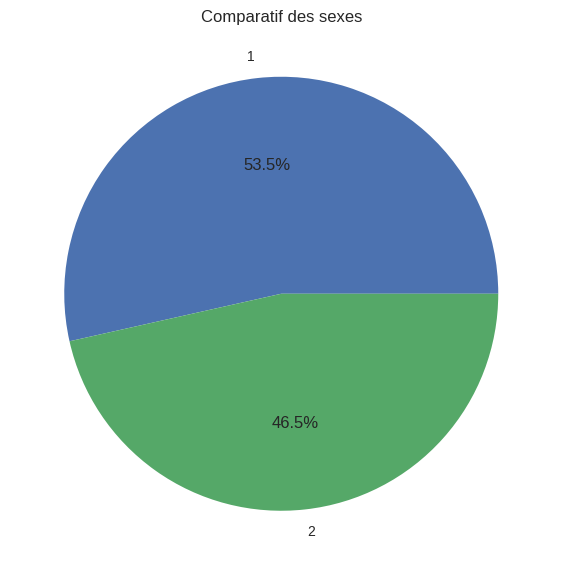

In [55]:
fig = plt.figure(figsize=(7,7),dpi=100,facecolor='w', edgecolor='k')
plt.axis("equal")
plt.title("Comparatif des sexes")
a = plt.pie(data.groupby("sexe").size(),labels = data.groupby("sexe").size().index,autopct='%1.1f%%')

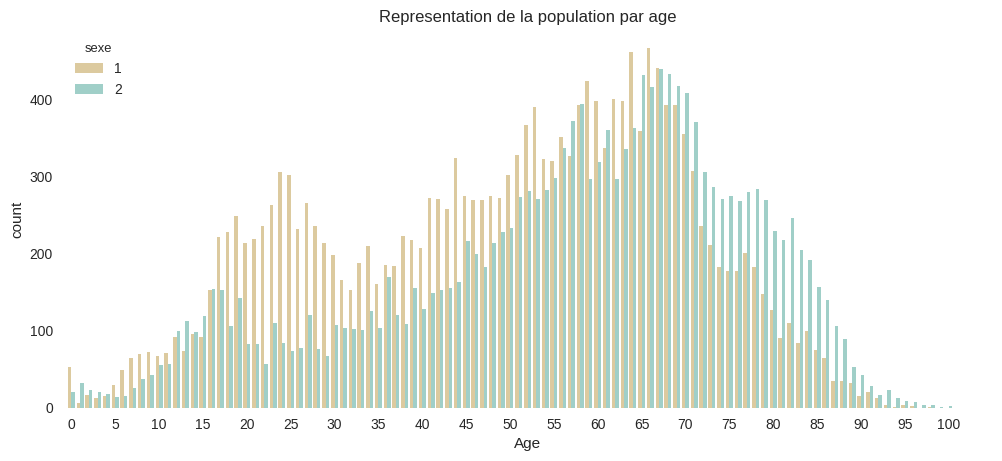

In [53]:
#plot distribution
fig = plt.figure(figsize=(12,5),dpi=100,facecolor='w', edgecolor='k')
a = sns.countplot(x="Age",hue="sexe",data=data,palette="BrBG")
a.set_frame_on(False)
a.set_xlim(-1,105)
a.set_title('Representation de la population par age')
a = a.set_xticklabels([x if x in range(0,105,5) else "" for x in range(len(set(data["Age"])))])


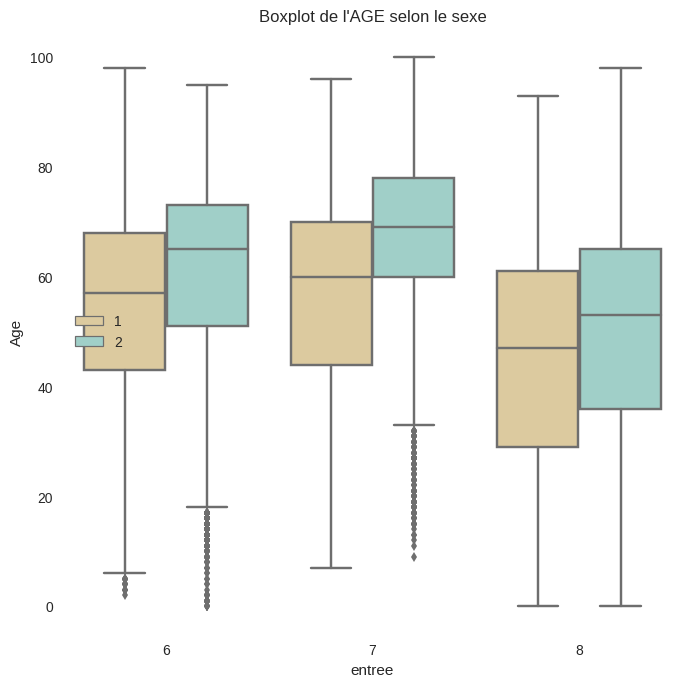

In [94]:
#plot description
plt.figure(figsize=(8,8),dpi=100)
ax = sns.boxplot(y="Age",x="entree",hue = "sexe",data=data,palette="BrBG") #,palette="Blues_d")
#ax = sns.swarmplot(x=cp["AGE"], color=".25")
ax.set_frame_on(False)
ax.set_title("Boxplot de l'AGE selon le sexe")
ax.legend(loc="center left")

- - **Code postal -> département**

**La variable "CP" est à traiter comme une variable catégorielle. Cela rejoint notre raisonnement précédent, de par l'interprétation géographique de cette variable.**

In [46]:
#regroup by postal county
#CP est un type entier reformater en string avec 0 devant
data['CP'] = data['CP'].apply(lambda x : str(x).zfill(5))
data['CP_departement']=data['CP'].apply(lambda x : x[0:2])

In [85]:
dpts_geojson = "../data/france-geojson-master/departements.geojson"

#Create indicators to plot
data["IDX"] = range(len(data))
temp = data.groupby("CP_departement").size()
temp = pd.DataFrame(temp).reset_index()
#temp[0] = temp[0].apply(lambda x : x if x > 6 else 0)

geo_path=dpts_geojson

#Let Folium determine the scale
map_ = folium.Map(location=[47.144417, 2.495796], zoom_start=5,tiles="Mapbox Bright")
map_.choropleth(geo_path, data=temp,
             #threshold_scale =  [0, 0.2,0.5,0.8,0.95],
             columns=['CP_departement', 0],
             key_on='feature.properties.code',
             fill_color='YlOrRd',fill_opacity=0.8, line_opacity=0.2,reset=True,highlight = True,
            legend_name='Distribution des clients')

map_.save("maps/Distribution des origines patients.html")
map_

In [ ]:
#threshold and discretize 

#Creation de la variable “chapitre” simplifiee : 
#Correlation la plus grande avec “NbSemaines”
def simple_chap(chapitre):
    if "08" in chapitre:
        return 0
    if "01" in chapitre:
        return 1
    else:
        return 2
data["T_chapitre_discretized"] = data["T_chapitre"].apply(lambda x : simple_chap(x))

thresh_practiciens = {
     u'Animateur' : 909,
     u'Assistant de service social':243,
     u'Autre intervenant':227,
     u'Di\xe9t\xe9ticien':81,
     u'\xc9ducateur sp\xe9cialis\xe9':913,
     u'\xc9ducateur sportif':781,
     u'Enseignant g\xe9n\xe9ral':1888,
     u'Ergonome':258,
     u'Ergoth\xe9rapeute':781,
     u'Infirmier':411,
     u'Masseurkin\xe9sith\xe9rapeute':1419,
     u'Moniteur d\u2019auto\xe9cole':338,
     u'Moniteur \xe9ducateur':1715,
     u'Orthophoniste':945,
     u'Orthoproth\xe9siste':84,
     u'Osteopathe':194,
     u'Psychologue':364,
     u'Psychomotricien':577
}

#Discretise for each practicien:
for col in practiciens:
    thresh = thresh_practiciens[col]
    data[u"%s_discretized"%col]  = data[col].apply(lambda x : 1 if x>0 and x<=thresh else (2 if x>thresh else 0))

